# XGBoost

## Input

1. .csv - produced by pre_processing.ipynb
2. The pre_processed input data includes following techniques:
   * MinMax Scaling
   * PCA
   * Correlation

## Output/Analysis

1. Visualising the accuracy of XGB with k-fold validation.
2. Comparing the accuracy of XGB model with and without PCA.   

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
acc = []
f1 =  []
acc1 = []
f11 =  []
df = pd.DataFrame()

In [2]:
def load_data(filename):
    return pd.read_csv(filename)

# Spilt the input file into test and train dataset

I/P: dataframe

O/P: x_cross_val, y_cross_val, x_test, y_test

In [3]:
def prep_training(network_data):
    return train_test_split(network_data, train_size=0.8, test_size=0.2, random_state=42)

# Hyperparameter Tuning for XGBoost

1.   List item
2.   List item



The following hyperparamter tuning has taken reference from:
1. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
2. https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead
3. https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [4]:
from pprint import pprint

Instead of all the above the parameters, we will just focus on tuning a few as given below:
We will try adjusting a few of the following set of hyperparameters:
1. n_estimators = number of trees in the foreset
2. max_depth = max number of levels in each decision tree
3. eta = Boosting learning rate (xgb’s “eta”)
4. colsample_bytree = colsample_bytree defines what percentage of features ( columns ) will be used for building each tree.


To use CV, we first need to create a parameter grid to sample from during fitting:

- n_estimators=[30,60]  
- max_depth = [10,15]
- eta=[0.1,0.5,1]# Maximum number of levels in tree
- colsample_bytree1=[ 0.5,1]


### RandomizedSearch CV versus GridSearchCV

Grid Search is good when we work with a small number of hyperparameters. However, if the number of parameters to consider is particularly high and the magnitudes of influence are imbalanced, the better choice is to use the Random Search. [Reference](https://towardsdatascience.com/machine-learning-gridsearchcv-randomizedsearchcv-d36b89231b10)

Therefore, we have used GridSearchCV.

In [5]:
def creatingParamterGrid():
    n_estimators = [30,60]   # Number of trees in random forest
    max_depth = [10,15] 
    eta=[0.1,0.5,1]# Maximum number of levels in tree
    colsample_bytree1=[ 0.5,1]
    # Create the parameter grid
    parameter_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'eta':eta,
               'colsample_bytree' : colsample_bytree1
    }
    return parameter_grid

## Cross-Validated Grid Search

We are now ready to create our grid-search object. We'll use each of the objects we've created thus far.
Instead of passing a `PredefinedSplit` object tothe `cv` paramter, we are simply passing the number of folds.

In [6]:
def prepToFindOptimalHyperParams(clf,parameter_grid):
    grid_search = GridSearchCV(estimator=clf, cv=3, param_grid = parameter_grid)
    return grid_search

## Training the Model

Now that we have created our `grid_search` object, we are ready to train our model.

In [7]:
def train(cross_val_df,grid_search):
    grid_search.fit(cross_val_df.drop("label",axis=1), cross_val_df["label"])
    Xpred = grid_search.predict(cross_val_df.drop("label",axis=1))
    print("accuracy on train is",accuracy_score(cross_val_df["label"],Xpred))

We are training models = (Number of unique Hyperparamter Combinations * number of folds) + 1

## Cross-validated Results

To examine the results individual fold, we use `grid_search`'s `cv_results_` attribute.
pd.DataFrame(grid_search.cv_results_).head()

## Optimal Hyperparamters

grid_search.best_params_
grid_search.best_score_

# Test the model and analyse it

In [8]:
def testXGBModel(test_df,grid_search,type):
    Ytest = test_df["label"]
    Ypred = grid_search.predict(test_df.drop("label",axis=1))
    print(classification_report(Ytest,Ypred))   
    acc1.append(accuracy_score(Ytest,Ypred))
    acc=accuracy_score(Ytest,Ypred)
    print('Accuracy of XGBoost Forest:',(acc)) 
    f1.append(f1_score(Ytest,Ypred))
    #df['f1']  = f1_score(Ytest, Ypred)
    plt.savefig('confusion_matrix'+type+'.jpg')
    cm = confusion_matrix(Ytest, Ypred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax) 
    print(cm)
    return acc1


# Main Function

In [9]:
def main(network_data,type): 
    clf = xgb.XGBClassifier(random_state=42,eval_metric='logloss')
    cross_val_df, test_df = prep_training(network_data)
    parameter_grid = creatingParamterGrid()
    pprint(parameter_grid)
    grid_search = prepToFindOptimalHyperParams(clf,parameter_grid)
    train(cross_val_df,grid_search)
    acc1=testXGBModel(test_df,grid_search,type)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search,acc1

# Classification with XGB without preprocessing

In [10]:
network_data = load_data('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/2.Data_Cleaning/cleaned_dataset_label_encoding.csv')

{'colsample_bytree': [0.5, 1],
 'eta': [0.1, 0.5, 1],
 'max_depth': [10, 15],
 'n_estimators': [30, 60]}
accuracy on train is 0.9745073688499937
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18675
           1       0.97      0.96      0.96     32860

    accuracy                           0.95     51535
   macro avg       0.95      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535

Accuracy of XGBoost Forest: 0.9522848549529446
[[17564  1111]
 [ 1348 31512]]
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 15, 'n_estimators': 60}
0.9504846271776085


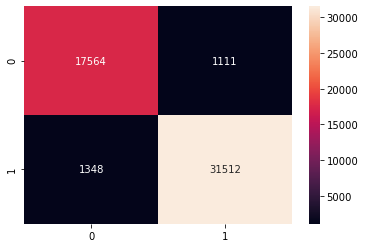

In [11]:
network_data = network_data.drop("attack_cat",axis=1)
import warnings
warnings.filterwarnings('ignore')
grid_search,acc1 = main(network_data,'withoutpreprocess')

In [12]:

df['Accuracy_xgb_without_pp'] =acc1
df['F1_score_xgb_without_pp']=f1


# Classification with XGB after MinMax Scaling 

In [13]:
network_data1 = load_data('../input/dataset_minmax.csv')

In [14]:
network_data1

,# dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1.833334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
1,1.333334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
2,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,...,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0,0
3,1.000000e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,...,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
4,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,...,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0,1
257669,8.429368e-03,0.856061,0.000000,0.4,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0,1
257670,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0,1
257671,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0,1


{'colsample_bytree': [0.5, 1],
 'eta': [0.1, 0.5, 1],
 'max_depth': [10, 15],
 'n_estimators': [30, 60]}
accuracy on train is 0.9745073688499937
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18675
           1       0.97      0.96      0.96     32860

    accuracy                           0.95     51535
   macro avg       0.95      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535

Accuracy of XGBoost Forest: 0.9522848549529446
[[17564  1111]
 [ 1348 31512]]
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 15, 'n_estimators': 60}
0.9503439454046302


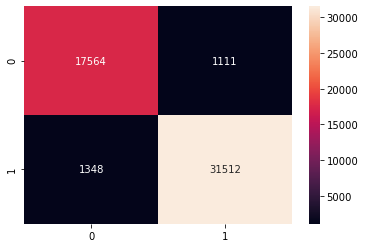

In [15]:
grid_search1,acc1= main(network_data1,'minmax')

In [16]:
pd.DataFrame(grid_search1.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.876383,0.362616,0.060347,0.007719,0.5,0.1,10,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.942020,0.943606,0.942834,0.942820,0.000648,22
1,6.550017,0.070348,0.068349,0.011816,0.5,0.1,10,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.944727,0.945847,0.945905,0.945493,0.000542,13
2,5.150554,0.024630,0.068680,0.006182,0.5,0.1,15,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.948685,0.947812,0.948728,0.948408,0.000422,4
3,9.938464,0.051883,0.115194,0.011453,0.5,0.1,15,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.950301,0.950170,0.950562,0.950344,0.000163,1
4,3.331765,0.029768,0.043677,0.001700,0.5,0.5,10,30,"{'colsample_bytree': 0.5, 'eta': 0.5, 'max_dep...",0.946022,0.947521,0.947506,0.947016,0.000703,12


In [17]:
df['Accuracy_xgb_mm'] =acc1[1]
df['F1_score1_xgb_mm']=f1[1]

In [18]:
df

,Accuracy_xgb_without_pp,F1_score_xgb_without_pp,Accuracy_xgb_mm,F1_score1_xgb_mm
0,0.952285,0.962448,0.952285,0.962448


# Classification with XGBoost after MinMax Scaling + Correlation analysis

In [19]:
network_data2 = load_data('../input/dataset_minmax_corr.csv')

{'colsample_bytree': [0.5, 1],
 'eta': [0.1, 0.5, 1],
 'max_depth': [10, 15],
 'n_estimators': [30, 60]}
accuracy on train is 0.9689382840621331
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18675
           1       0.96      0.96      0.96     32860

    accuracy                           0.94     51535
   macro avg       0.94      0.94      0.94     51535
weighted avg       0.94      0.94      0.94     51535

Accuracy of XGBoost Forest: 0.9441932667119434
[[17269  1406]
 [ 1470 31390]]
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 15, 'n_estimators': 60}
0.9419854682564327


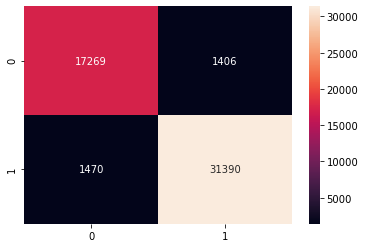

In [20]:
grid_search2,acc1 = main(network_data2,'minmax_corr')

In [21]:
pd.DataFrame(grid_search2.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.242639,0.333492,0.046344,0.001700,0.5,0.1,10,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.936067,0.935922,0.936852,0.936281,0.000409,15
1,8.549126,0.630300,0.087685,0.015416,0.5,0.1,10,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.938105,0.939109,0.938992,0.938735,0.000448,10
2,6.073747,0.020422,0.055346,0.002868,0.5,0.1,15,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.940695,0.941045,0.941524,0.941088,0.000340,2
3,11.901038,0.195511,0.108025,0.015583,0.5,0.1,15,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.942209,0.941307,0.942441,0.941985,0.000489,1
4,3.846255,0.038276,0.098689,0.041355,0.5,0.5,10,30,"{'colsample_bytree': 0.5, 'eta': 0.5, 'max_dep...",0.938454,0.939604,0.939501,0.939186,0.000519,8


In [22]:
df['Accuracy2_xgb_mm_corr'] =acc1[2]
df['F1_score2_xgb_mm_corr']=f1[2]

In [23]:
df

,Accuracy_xgb_without_pp,F1_score_xgb_without_pp,Accuracy_xgb_mm,F1_score1_xgb_mm,Accuracy2_xgb_mm_corr,F1_score2_xgb_mm_corr
0,0.952285,0.962448,0.952285,0.962448,0.944193,0.956196


# Classification with XGBoost after Dimension Reduction (using PCA)

In [24]:
network_data3 = load_data('../input/dataset_pca.csv')

{'colsample_bytree': [0.5, 1],
 'eta': [0.1, 0.5, 1],
 'max_depth': [10, 15],
 'n_estimators': [30, 60]}
accuracy on train is 0.9806634390553901
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     18675
           1       0.94      0.95      0.95     32860

    accuracy                           0.93     51535
   macro avg       0.93      0.92      0.92     51535
weighted avg       0.93      0.93      0.93     51535

Accuracy of XGBoost Forest: 0.929484816144368
[[16575  2100]
 [ 1534 31326]]
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 15, 'n_estimators': 60}
0.92790751534292


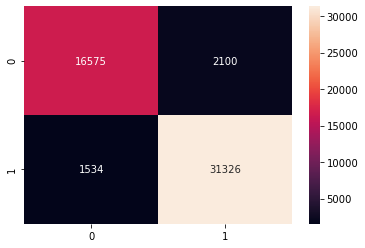

In [25]:
grid_search3,acc1 = main(network_data3,'pca')

In [26]:
pd.DataFrame(grid_search3.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.477010,0.142430,0.048011,0.005100,0.5,0.1,10,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.919462,0.921063,0.921484,0.920670,0.000871,17
1,12.659120,0.245229,0.251203,0.235108,0.5,0.1,10,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.923741,0.924978,0.924744,0.924487,0.000537,5
2,9.265510,0.116761,0.073016,0.010804,0.5,0.1,15,30,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.926491,0.926913,0.926432,0.926612,0.000214,3
3,17.998373,0.722311,0.128021,0.012833,0.5,0.1,15,60,"{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.927714,0.928703,0.927305,0.927908,0.000587,1
4,5.808526,0.075193,0.043676,0.002358,0.5,0.5,10,30,"{'colsample_bytree': 0.5, 'eta': 0.5, 'max_dep...",0.920088,0.922707,0.921629,0.921475,0.001075,14


In [27]:
df['Accuracy2_xgb_pca'] =acc1[3]
df['F1_score2_xgb_pca']=f1[3]

In [28]:
df

,Accuracy_xgb_without_pp,F1_score_xgb_without_pp,Accuracy_xgb_mm,F1_score1_xgb_mm,Accuracy2_xgb_mm_corr,F1_score2_xgb_mm_corr,Accuracy2_xgb_pca,F1_score2_xgb_pca
0,0.952285,0.962448,0.952285,0.962448,0.944193,0.956196,0.929485,0.945177


In [29]:
def displayAnalysisGraphs(list1, acc,f1,model):
  plt.scatter(list1,acc)
  for i in range(len(list1)):
    acc[i]=float('{:,.3f}'.format(acc[i]))
    plt.annotate(str(acc[i]), xy=(list1[i], acc[i]))
  plt.ylabel("Accuracy")
  plt.title("Accuracy for dataset after different preprocessing techniques for "+model)
  plt.savefig("Accuracy"+model+".png")
  plt.show()
  plt.scatter(list1,f1)
  for i in range(len(list1)):
    f1[i]=float('{:,.3f}'.format(f1[i]))
    plt.annotate(str(f1[i]), xy=(list1[i], f1[i]))
  plt.ylabel("F1 score")
  plt.title("F1 scores for dataset after different preprocessing techniques for "+model)
  plt.savefig("F1_scores"+model+".png")
  plt.show()

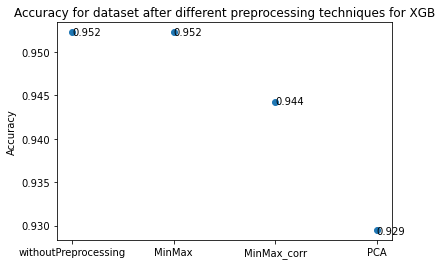

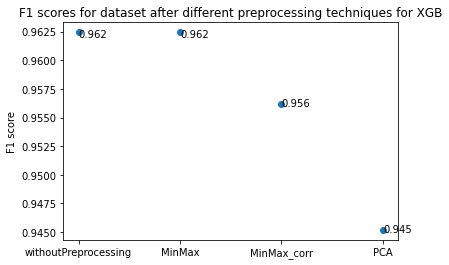

In [30]:
list1 = ['withoutPreprocessing','MinMax','MinMax_corr','PCA']
displayAnalysisGraphs(list1,acc1,f1,"XGB")

In [31]:
df.to_csv("XGB_result.csv")